# Init Enviorment

In [ ]:
!pip install easyocr
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 70.8 MB 10 kB/s 
     |████████████████████████████████| 47.6 MB 1.5 MB/s 
Found existing installation: opencv-python-headless 4.5.4.60
Uninstalling opencv-python-headless-4.5.4.60:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.4.60.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/p

In [ ]:
import easyocr
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from google.colab.patches import cv2_imshow
from imutils.contours import sort_contours
import os
import os.path
import math
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from difflib import SequenceMatcher #Used to get similarity between two strings. Used for OCR to find best match in database.

#Init models 


In [ ]:
#Shape Classifyer

df = pd.read_csv("humoments.csv")
x = df[['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']]
y = df[['shape']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)
clfs = RandomForestClassifier(n_estimators=100)
clfs.fit(x_train, y_train.values.ravel())
y_pred = clfs.predict(x_test)
print("ACCURACY OF SHAPE CLASSIFIER:", metrics.accuracy_score(y_test, y_pred)) 


#Color Classifier
df = pd.read_csv("hsvrgbDataset.csv")
x = df[['h', 's', 'v', 'r', 'g', 'b']]
y = df[['color']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)
clfc = RandomForestClassifier(n_estimators=100)
clfc.fit(x_train, y_train.values.ravel())
y_pred = clfc.predict(x_test)
print("ACCURACY OF THE COLOR CLASSIFIER:", metrics.accuracy_score(y_test, y_pred))


reader = easyocr.Reader(['en'])

ACCURACY OF SHAPE CLASSIFIER: 0.998812351543943


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


ACCURACY OF THE COLOR CLASSIFIER: 0.9311306143520909
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

# Image Cleaning


In [ ]:
def avgFrame(img):
  #This function takes in an image, performs kmeans on it. This is used to extract the gray background in the sample images
  
  pixel_values = img.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  stopCritera = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.2)
  k = 4
  _, labels, (centers) = cv2.kmeans(pixel_values, k, None, stopCritera, 1, cv2.KMEANS_RANDOM_CENTERS)
  centers = np.uint8(centers)
  labels = labels.flatten()
  segmented_image = centers[labels.flatten()]
  segmented_image = segmented_image.reshape(img.shape)

  return segmented_image, centers

def removeGray(img, raw):
  #This function removes the gray from the image, and replaces it with black 
  imgk, _ = avgFrame(img)
  x, y, c = imgk.shape
  x,y,h = img.shape
  pixel = imgk[x-30:, y-30:y ]
 
  img = np.where(imgk == (pixel[0][0]), 0, imgk)
  _, mask = cv2.threshold(img, thresh = 10, maxval = 255, type = cv2.THRESH_BINARY)
  newimage = cv2.bitwise_and(raw, mask)
  return newimage


# Shape Classification


Shapes are classified by using humoments to create a dataset to build a randomForest classification model from the sample data.

In [ ]:
def classifyShape(huMoments):
  #This function takes in 7 values representing the humoments of pill, and classifies whether it's a round, oval or capsul pill. Will need more humoment data for other shapes. 
  testData = pd.DataFrame(huMoments)
  testData.columns = ['h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']
  pred = clfs.predict(testData)
  return pred[0]


def getHuMoments(img):
  img = removeGray(img, img)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print("Gray image from getHuMoments")
  cv2_imshow(gray)
  _, mask = cv2.threshold(gray, thresh = 5, maxval=255, type=cv2.THRESH_BINARY)
  moments = cv2.moments(mask)
  huMoments = cv2.HuMoments(moments)
  print("HUMoments")
  cv2_imshow(mask)
  for i in range(0,7):
    huMoments[i] = -1* np.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
  huMoments = huMoments.flatten()
  return huMoments

# Color Classifier

In [ ]:
def classifyColor(hsv):
  testData = pd.DataFrame(hsv)
  testData.columns = ['h', 's', 'v', 'r', 'g', 'b']
  pred = clfc.predict(testData)
  return pred[0]


def getColor(img):
  #The input image should have exactly 1 image in a solid color background
  #The input image has it's rgb values extracted, then converts it to hsv
  #where those values are also extracted. A dataset is created, and then 
  #Classified with a random forest. Returns the primary and secondary colors
  #In each image. 
  

  img = removeGray(img, img)
  original = img.copy()

  #RGB portion
  img.reshape(-1,3)
  unique, counts = np.unique(img.reshape(-1,3), axis=0, return_counts = True)
  counts = counts.reshape(counts.shape[0],1)
  pixels = np.concatenate((unique, counts),1)
  pixels = pixels[pixels[:,3].argsort()]
  pixels = pixels[-50:]

  rgbValues = []
  for x in pixels:
    rgb = (x[0], x[1], x[2])
    rgbValues.append(rgb)
  print("BGR PORTION")
  cv2_imshow(img)
  #HSV portion
  img = cv2.cvtColor(original, cv2.COLOR_BGR2HSV)
  print("HSV PORTION")
  cv2_imshow(img)
  img.reshape(-1,3)
  unique, counts = np.unique(img.reshape(-1,3), axis=0, return_counts = True)
  counts = counts.reshape(counts.shape[0],1)
  pixels = np.concatenate((unique, counts),1)
  pixels = pixels[pixels[:,3].argsort()]
  pixels = pixels[-50:]

  hsvValues = []
  for x in pixels:
    hsv = (x[0], x[1], x[2])
    hsvValues.append(hsv)
  
  #Creating a dataframe of the values
  dc = pd.DataFrame(hsvValues)
  df = pd.DataFrame(rgbValues)
  df_collective = pd.concat([dc, df], axis = 1)
  df_collective.columns = [['h', 's', 'v', 'r', 'g', 'b']]


  colors = []
  for x in range(0,49):
    h, s, v, r, g, b = df_collective.iloc[x]
    data = [h,s,v,r,g,b]
    colors.append(classifyColor([data]))

  colordf = pd.DataFrame(colors)
  colordf.columns = ['colors']
  colorsdf = []

  for each in colordf['colors'].unique():
    subset = colordf[colordf['colors'] == each]
    #print(each)
    #print(len(subset), each)
    colorsdf.append((len(subset), each))


  colorsdf = pd.DataFrame(colorsdf)
  colorsdf.columns = ['count', 'color']
  colorsdf.sort_values(by = ['count'], ascending = False, inplace=True)
  
  primary = colorsdf.iloc[0]['color']

  if len(colorsdf) < 2:
    secondary = "NONE"
  
  else:
    secondary = colorsdf.iloc[1]['color']

  
  #print((colorsdf.iloc[0]['color'], colorsdf.iloc[1]['color']))
  return primary, secondary;



# OCR Methods


In [ ]:
def similar(a, b):
  return SequenceMatcher(None, str(a), str(b)).ratio()



```
# This is formatted as code
```

# Putting it all together

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


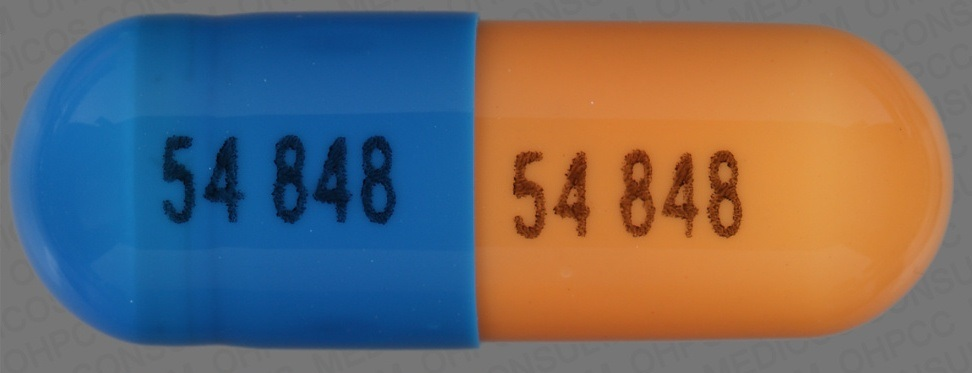

BGR PORTION


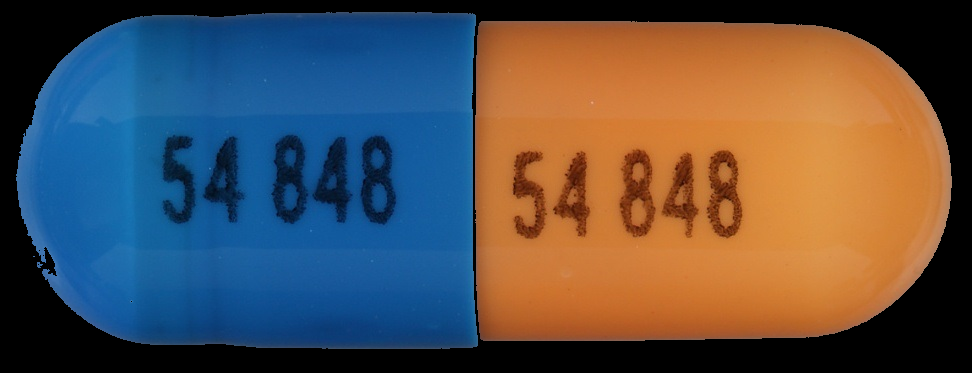

HSV PORTION


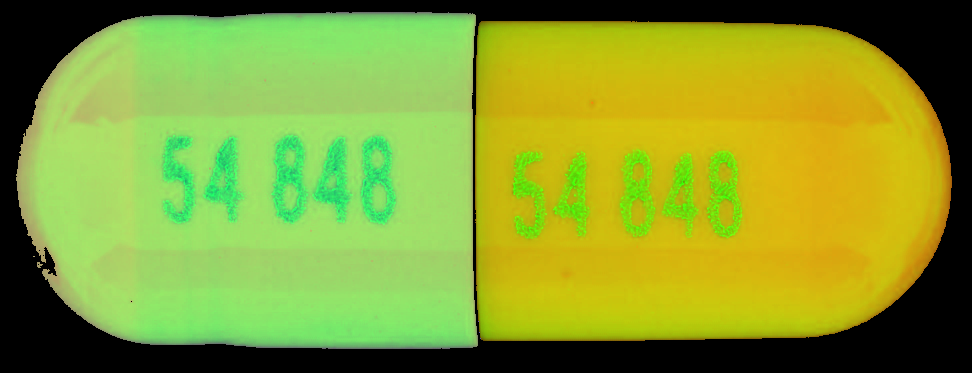

Gray image from getHuMoments


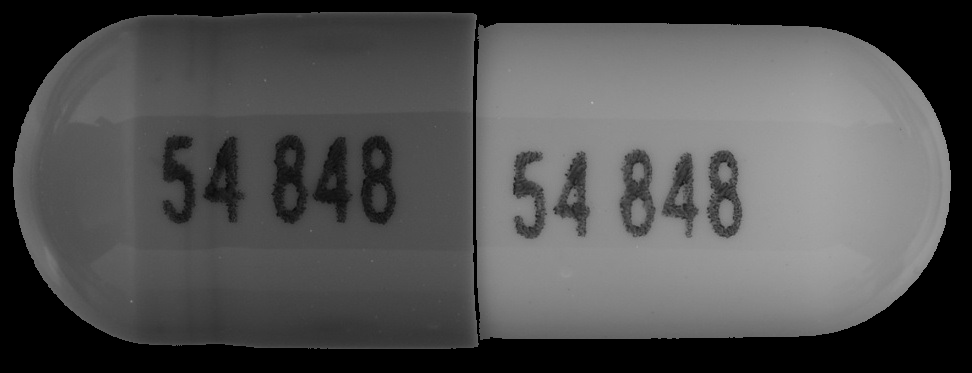

HUMoments


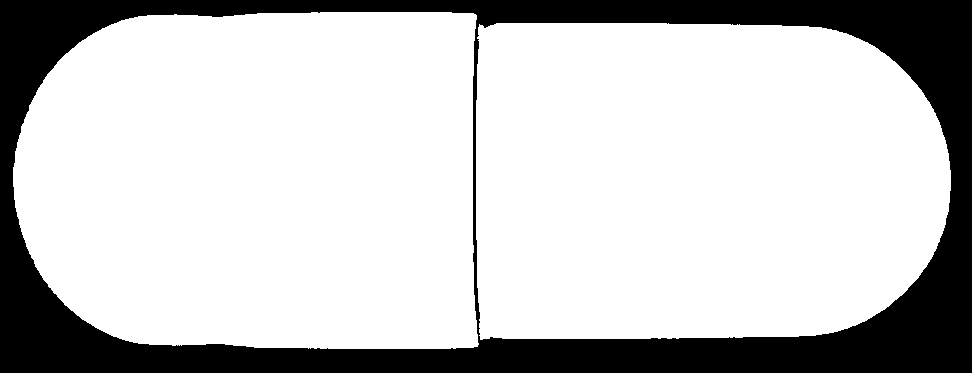

SHAPE: CAPSULE
COLORS (Primary/secondary): BLUE ORANGE
MARKINGS: 54;848;54;848;
With a confidence of 60.0 %, Predcition is:
medicine_name                             Mycophenolate Mofetil
splshape_text                                           CAPSULE
splscore                                                    1.0
splimprint                                               54;848
splcolor                                          C48333;C48332
splcolor_text                                        BLUE;BROWN
pillbox_color_text                                          NaN
spl_strength                      MYCOPHENOLATE MOFETIL 250 mg;
rxstring              mycophenolate mofetil 250 MG Oral Capsule
ndc9                                                     540163
ndc_labeler_code                                             54
ndc_product_code                                            163
Name: 7083, dtype: object


In [ ]:
#This slide is a working example of the capstone in action. Right now images need to be individual. 

img = cv2.imread("00054-0163-29_RXNAVIMAGE10_D144E897.jpg") #Change to what ever image is being passed in
pilldata = pd.read_csv('cleanedPillboxData.csv')
cv2_imshow(img)

#Get Color/s
primary, secondary = getColor(img)

#Get Shape
huMoments = getHuMoments(img)
result = classifyShape([huMoments])

#Get characters
characters = reader.readtext(img)


text = ""
for res in characters:
   if res[2] > .4:
    text += res[1] + " "

#FilterData
text = text.replace(' ', ';')
text = text.replace('mg', '')

subsetdf = pilldata[pilldata['splshape_text'] == result]

max = 0
iofmax = 0
for i, r in subsetdf.iterrows():
  compare = similar(str(r['splimprint']), text)
  if compare > max:
    max = compare
    iofmax = i
  #print(similar(r['splimprint'], text))
  #print(r['splimprint'])

print("SHAPE:", result)
print("COLORS (Primary/secondary):",primary, secondary)
print("MARKINGS:", text)
print("With a confidence of", (max *100), "%, Predcition is:")
print(subsetdf.loc[iofmax])

In [ ]:
pilldata = pd.read_csv('cleanedPillboxData.csv')
print(len(pilldata))

subsetdf = pilldata[pilldata['splshape_text'] == result]
print("AFTER SHAPE CLASSIFIER:", len(subsetdf))
text = text.replace(' ', ';')
text = text.replace('mg', '')
print(text)
max = 0
iofmax = 0
for i, r in subsetdf.iterrows():
  compare = similar(str(r['splimprint']), text)
  if compare > max:
    max = compare
    iofmax = i
  #print(similar(r['splimprint'], text))
  #print(r['splimprint'])
print(max)
print(subsetdf.loc[iofmax])
subsetdf = subsetdf[subsetdf['splimprint'] == '54;848']
print("AFTER OCR:",len(subsetdf))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


83925
AFTER SHAPE CLASSIFIER: 21348
84;3251;100;
0.6896551724137931
medicine_name                                           Strattera
splshape_text                                             CAPSULE
splscore                                                      1.0
splimprint                                      LILLY;3251;100;mg
splcolor                                                   C48332
splcolor_text                                               BROWN
pillbox_color_text                                            NaN
spl_strength                    Atomoxetine hydrochloride 100 mg;
rxstring              atomoxetine 100 MG Oral Capsule [Strattera]
ndc9                                                        23251
ndc_labeler_code                                                2
ndc_product_code                                             3251
Name: 2463, dtype: object
AFTER OCR: 3
